In [9]:
%run ../talktools.py

<Figure size 432x288 with 0 Axes>

# MCMC Convergance 

### AY 128/256 (UC Berkeley, 2021-2024)

* What is convergence for MCMC?
 - Working definition: The property that the chain is in equilbrium, stationary, and/or not sensitive to initial conditions.
 - __Convergence can never be proven__
 - Our best bet is to learn to look for situations when chain hasn't coverned, and to get in the habit of carefully checking the results of any model fitting

#### Sampling from a 1-D Gaussian

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline
import pymc as pm
import arviz as az
from arviz import plot_trace as traceplot

# set up a pymc model to sample from a 1-D Gaussian with mean=0 and sigma=1.
with pm.Model() as model:
    mean, sigma = 0, 1
    vals = pm.Normal('x', mu=mean, sigma=sigma)
    trace = pm.sample(5000, tune=5000, chains=4, cores=2, discard_tuned_samples=False)#, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [x]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 11 seconds.


In [34]:
# print pymc summary statistics
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.007,0.999,-1.815,1.936,0.011,0.008,8659.0,14658.0,1.0


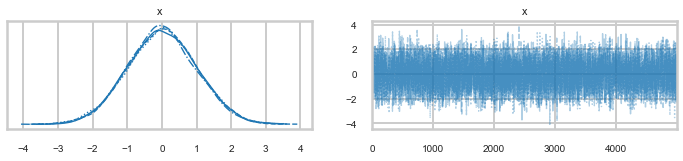

In [35]:
# make trace plots
with model:
    traceplot(trace)

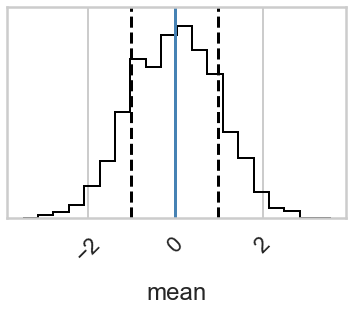

In [13]:
# make a (pointless) corner plot
import corner
fig = plt.figure(figsize=(8,5))
_ = corner.corner(trace, quantiles=[0.16, 0.84], truths=[mean], labels=['mean'], fig=fig)

Once we have samples from the posterior we can do cool things:

Suppose we have B samples $\theta_1$...$\theta_B$ from the posterior $p(\theta|$**X**):

1) **Posterior mean**: 
   
The exact equation $E[\theta|$**X**] = $\int \theta~ p(\theta|$**X**)$~d\theta$

Using the sample $E[\theta|$**X**] $\approx \frac{1}{B} \sum_{b=1}^B \theta_b$

2) **Marginalization**: 
   
The exact equation $p(\theta_1|$**X**) = $\int p(\theta_1,\theta_2,..\theta_p|$**X**)$~d\theta_2~d\theta_3...d\theta_p$

Using the sample $p(\theta_1|$**X**) $\sim \theta_{1,1} ... \theta_{1,B}$

*That is, record the parameter of interest $\theta_1$ from each sample.*

3) **Prediction**: 
   
The exact equation $p(\tilde{X}|$**X**) = $\int p(\tilde{X}|\theta)~p(\theta|$**X**)$~d\theta$

Using the sample $p(\tilde{X}|$**X**) $\sim \tilde{x_1} | \theta_{1} ... \tilde{x_B} | \theta_{B}$

*That is, take each sample of $\theta$ and determine a value for $x$.*

## Some general advice for checking goodness of fit:

Determining whether an MCMC has converged can be difficult, especially in high-dimensional parameter spaces: "This can be a difficult subject to discuss because it isn’t formally possible to guarantee convergence for any but the simplest models, and therefore any argument that you make will be circular and heuristic."

Here's a basic overview of how you can convince yourself and others you are on the right track.

- **First check** - start multiple chains from different starting values and see that they converge to the same place
- **More formal methods** - Raftery-Lewis, Geweke, autocorrelation, etc.
- **Goodness of fit** - Posterior Predictive Checks which simulate data from your fitted model and compare to the observed data (checks convergence AND the suitability of the chosen model)

See https://pkgw.github.io/mcmc-reporting/ and https://rlhick.people.wm.edu/stories/bayesian_5.html for some details and insights.


## Convergence Diagnostics

https://pymcmc.readthedocs.io/en/latest/modelchecking.html

A number of diagnostics (both formal and informal) exist:

- Geweke score: compares mean of beginning of chain with mean of end

Geweke score = $\frac{\bar{\theta}_e - \bar{\theta}_b}{\sqrt{Var(\theta_e) + Var(\theta_b)}}$

- Gelman-Rubin: compare variance between chains to variance of single chain.  For a well converged chain the G-R stat should approach 1. Values greater than typically 1.1 indicate that the chains have not yet fully converged.

In [ ]:
#from arviz.stats import geweke
from arviz.stats import rhat

### Acceptance Fraction 

This is fraction of proposed steps were accepted.

From https://pkgw.github.io/mcmc-reporting/ : you should report the "jump acceptance fractions computed for each chain, or a summary of them if there are many chains and/or parameters. Acceptance fractions outside the range of 10–90% suggest that the sampler is not well-matched to your problem and are cause for concern, since your samples may not be fully exploring the posterior distribution."

For pymc/NUTS, it gives you a warning if you miss the target acceptance fraction.

Why might an acceptance fraction too high/low cause problems?

### Autocorrelation

A good heuristic for assessing convergence of samplings is the integrated autocorrelation time.  The integrated autocorrelation time quantifies "the effects of sampling error on your results. The basic idea is that the samples in your chain are not independent and you must estimate the effective number of independent samples." (https://emcee.readthedocs.io/en/latest/tutorials/autocorr/#autocorr). 

This statistic makes more sense for a M-H or similar type of non-adaptive sampler.

See also [these lecture notes](https://pdfs.semanticscholar.org/0bfe/9e3db30605fe2d4d26e1a288a5e2997e7225.pdf).


array([<AxesSubplot: title={'center': 'x\n0'}>,
       <AxesSubplot: title={'center': 'x\n1'}>], dtype=object)

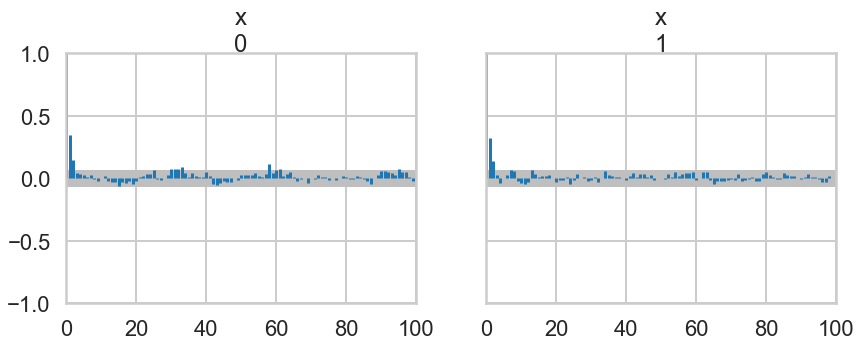

In [14]:
# you can make an autocorrelation plot easily in PyMC
az.plot_autocorr(trace)

### Exercise for the reader -- check out correlation statistics with a multi-dimensional Gaussian

In [ ]:

# this setups up sampling for a multi-dimensional Gaussian for you to play around with
with pm.Model() as model:
    ndim = 2
    np.random.seed(42)
    means = np.random.rand(ndim)

    cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
    cov = np.triu(cov)
    cov += cov.T - np.diag(cov.diagonal())
    cov = np.dot(cov, cov)
    
    vals = pm.MvNormal('vals', mu=means, cov=cov, shape=(2, 2))
    

    trace = pm.sample(draws=1000, tune=100, chains=2, cores=2, discard_tuned_samples=False)




In [ ]:
print(means)
az.summary(trace)

In [ ]:
traceplot(trace)

samples = pm.trace_to_dataframe(trace)
#_ = corner.corner(samples, quantiles=[0.16, 0.84], truths=[means[0], means[1], means[0], means[1]])

In [ ]:
# look at the autocorrelation plots for each chain for each variable
az.plot_autocorr(trace)